In [ ]:
import sys
import math
import numpy as np
import scipy.constants
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

sys.path.append('/media/nicolas/1ACD-5533/MesScripts/vaporisation/package/')
import heterogeneous
import PFC
import pressure

def exp_func(x,a,b,c):
    value = a*np.exp(b*x)+c
    return value

def poly_func(x,a,b,c):
    value = a*np.power(x,2)+b*x+c
    return value

def linear_func(x,a,b):
    value = a*x+b
    return value

On se place dans le cas d'une onde de fréquence $f=1$ MHz à une température de $T = 25$ °C.

In [2]:
T = 25 + scipy.constants.zero_Celsius
f = 1e6

La goutte est composée de perfluorhexane (PFH)

In [3]:
PFH = PFC.PFC('PFH')

Les tensions interfaciales pour le cas d'une goutte de PFH suspendue dans l'eau sont $\gamma_{lw} = 0.025$ N/m, $\gamma_{gw} = 0.038$ N/m et $\gamma_{gl} = 0.012$ N/m pour les interfactes PFH liquide/eau, PFH gazeux/eau et PFH gazeux/PFH liquide.

In [4]:
g_lw = 0.025
g_gw = 0.038
g_gl = 0.012

La tension interfaciale $\gamma_{gw,0}$ de l'interface entre l'eau et le PFH gazeaux est pris égale à celle de l'interface entre l'eau et l'air, soit 0.072 N/m

In [5]:
g_gw_0 = 0.072

Pour des gouttes ou bulles très petites, les tensions interfaciales sont reduites et peuvent être calculées grâce à la longueur de Tolman $\delta = 4$ &Aring;.

In [6]:
delta = 4e-10
k = 10

Lors de la création du nucléus gazeux, les tensions interfaciales  $\gamma_{lw}$ et $\gamma_{gl}$ ne varient pas tandis que $\gamma_{gw}$ varie avec la taille du nucléus et du rayon de la goutte suivant une loi logarithmique $\gamma_{gl,eff} = a e^{bx} + c$.

In [7]:
effective_g_gl = exp_func

On ne connaît pas les valeurs $a$, $b$, $c$ notre cas (on les a déterminer dans le glyérol mais pas dans l'eau). 
Pour simplier, on suppose que la valeur de $b$ (donne la courbure de la courbe) n'as pas changé, elle vaut donc $-1.3 \times 10^{5}$

In [8]:
b = -1.3e5

La valeurs de $a$ et $c$ doivent être choisies de manière à ce que  $\gamma_{gl,eff} < \gamma_{gl}$ et $a > c$

In [9]:
R = np.arange(0.1,31,0.1)*1e-6
N = len(R)

for a in np.arange(0.038,0.002,-0.001):
    for c in np.arange(0.030,0.001,-0.001):
        model = heterogeneous.external(PFH, T, f, g_gl, g_lw, g_gw, g_gw_0, k, delta, a, b, c) 
        P_het = np.zeros(N)
        try:
            for i in range(0,N):
                args = [(R[i], 'soft')]
                P0 = -1e6
                valueP = scipy.optimize.root(model.func_P, P0, args=args, method='hybr')
                P_het[i] = valueP.x[0]
                if P_het[i] == P0:
                    break
            else:
                if a>c:
                    print(round(a,3),round(c,3))
        except:
            continue



0.019 0.014
0.018 0.015
0.017 0.016
0.017 0.015
0.016 0.015
0.016 0.014
0.015 0.014


Pour le PFH, on fait le choix suivant pour les valeurs $a_{PFH}$ et $c_{PFH}$

In [10]:
a_PFH = 0.015
c_PFH = 0.014

Le comportement de $\gamma_{gl,eff}$ est

Text(0, 0.5, '$\\gamma_{gw}$')

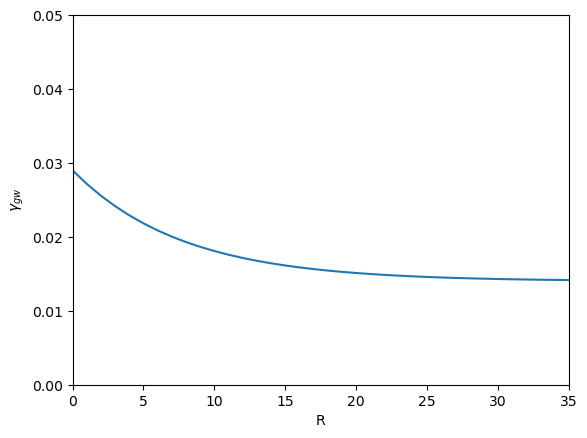

In [11]:
R = np.arange(0,36)*1e-6
plt.plot(R*1e6,effective_g_gl(R,a_PFH,b,c_PFH))
plt.xlim(0,35)
plt.ylim(0,0.05)
plt.xlabel('R')
plt.ylabel('$\gamma_{gw}$')


Le seuil de vaporisation $P^{1}_{0.5}$ (i.e. pression pour laquelle il y a 1/2 chance d'observer la vaporisation d'une goutte) est donné ci-dessous en fonction du rayon de la goutte

(0.0, 10.0)

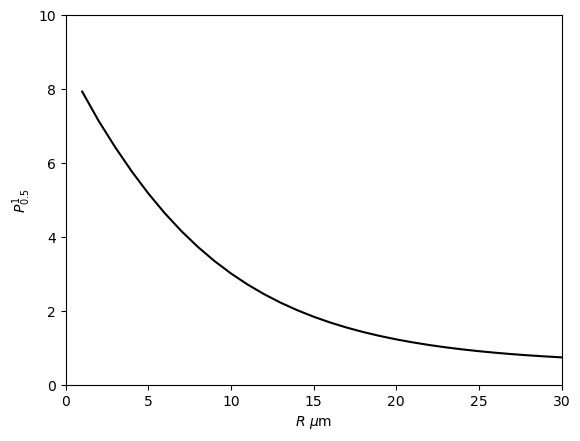

In [12]:
R = np.arange(1,31,1)*1e-6
N = len(R)

model = heterogeneous.external(PFH, T, f, g_gl, g_lw, g_gw, g_gw_0, k, delta, a_PFH, b, c_PFH) 
P_het = np.zeros(N)

for i in range(0,N):
    args = [(R[i], 'soft')]
    P0 = -0.2e6
    valueP = scipy.optimize.root(model.func_P, P0, args=args, method='hybr')
    P_het[i] = valueP.x[0]
    
plt.plot(R*1e6,-P_het*1e-6,'k')
plt.xlabel('$R$ $\mu$m')
plt.ylabel('$P^{1}_{0.5}$')
plt.xlim(0,30)
plt.ylim(0,10)


Dans expériences, la concentration de gouttes était en moyenne de $3 \times 10^{10}$ gouttes/mL et le volume de notre focale est de 10 &mu;L

Donc, nombre de gouttes insonifié est $n$

In [22]:
n = 3e10*10e-3
print(n)

300000000.0


Alors le seuil de pression de vaporisation pour $N$ gouttes insonifié est $P^{(n)}_{0.5} = P^{(1)}_{0.5} - \sigma^{(1)}[d_{n} + c_{n}\ln(\ln(2))]$

Il semble que dans cette équation, $\sigma^{1}$ dépend de la taille de la goutte, je cherche une fonction qui reproduit nos résultats 

(0.0, 2.0)

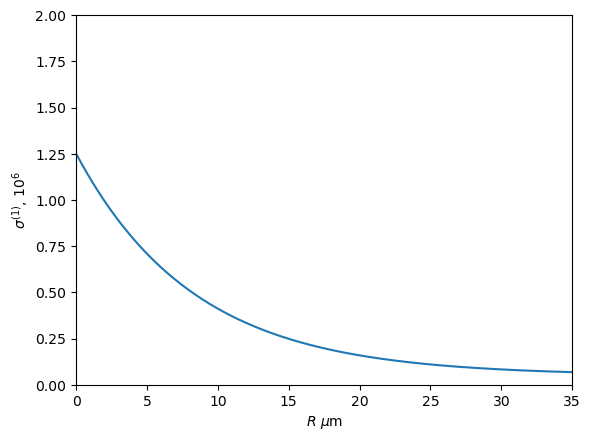

In [26]:
sigma = exp_func
a_sigma = 1.2e6
b_sigma = -12e4
c_sigma = 0.5e5
x = np.arange(0,40,0.1)*1e-6
plt.plot(x*1e6,sigma(x,a_sigma,b_sigma,c_sigma)*1e-6)
plt.xlabel('$R$ $\mu$m')
plt.ylabel('$\sigma^{(1)}$, $10^6$')
plt.xlim(0,35)
plt.ylim(0,2)

(0.0, 10.0)

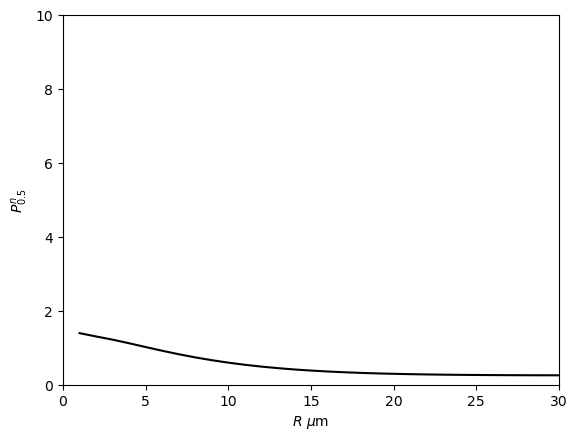

In [27]:
Pn = pressure.P_n(n,-P_het,sigma(R,a_sigma,b_sigma,c_sigma))
plt.plot(R*1e6,Pn*1e-6,'k')
plt.xlabel('$R$ $\mu$m')
plt.ylabel('$P^{n}_{0.5}$')
plt.xlim(0,30)
plt.ylim(0,10)

In [28]:
print('Pression de vaporisation ', round(Pn[0]*1e-6,1),' MPa, pour un rayon de ', R[0]*1e6, ' micromètre')
print('Pression de vaporisation ', round(Pn[4]*1e-6,1),' MPa, pour un rayon de ', R[4]*1e6, ' micromètre')

Pression de vaporisation  1.4  MPa, pour un rayon de  1.0  micromètre
Pression de vaporisation  1.0  MPa, pour un rayon de  5.0  micromètre


Si j'affiche la courbe de probabilité

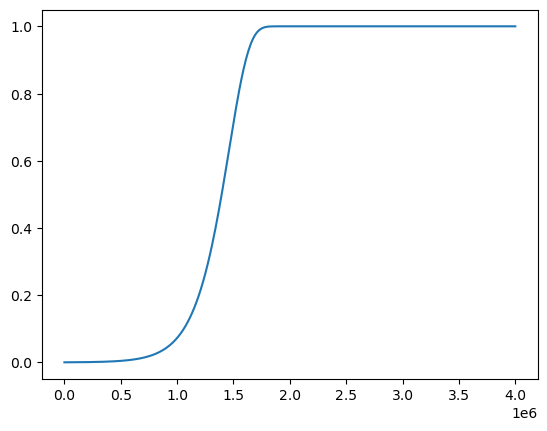

In [29]:
P = np.arange(0,4.01,0.01)*1e6
plt.plot(P, pressure.p_n(n,P,-P_het[0],sigma(R[0],a_sigma,b_sigma,c_sigma)))

C'est une courbe équivalente à celle qu'on vous a donnée pour les concentrations utilisées, maintenant je prédis la valeur expérimentale  !correcte !

Maintenant je vais augmenter le nombre de goutte, dans ma focale j'avais $5 \times 10^{5}$ gouttes, si je monte à $5 \times 10^{6}$ gouttes alors

Pression de  1.0  MPa, pour un rayon de  1.0  micromètre
Pression de  0.8  MPa, pour un rayon de  5.0  micromètre


(0.0, 10.0)

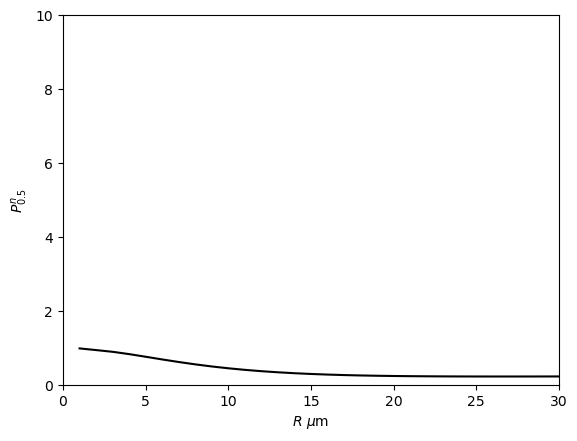

In [30]:
n = 3e9
Pn = pressure.P_n(n,-P_het,sigma(R,a_sigma,b_sigma,c_sigma))
print('Pression de ', round(Pn[0]*1e-6,1),' MPa, pour un rayon de ', R[0]*1e6, ' micromètre')
print('Pression de ', round(Pn[4]*1e-6,1),' MPa, pour un rayon de ', R[4]*1e6, ' micromètre')
plt.plot(R*1e6,Pn*1e-6,'k')
plt.xlabel('$R$ $\mu$m')
plt.ylabel('$P^{n}_{0.5}$')
plt.xlim(0,30)
plt.ylim(0,10)

et la courbe de probabilité donne

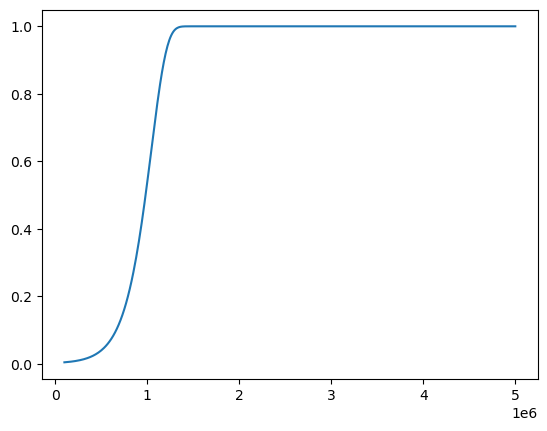

In [31]:
P = np.arange(0.1,5.01,0.01)*1e6
plt.plot(P, pressure.p_n(n,P,-P_het[0],sigma(R[0],a_sigma,b_sigma,c_sigma)))

Maintenant je vais augmenter le nombre de goutte, dans ma focale j'avais $5 \times 10^{5}$ gouttes, si je monte à $5 \times 10^{7}$ gouttes alors

Pression de  0.6  MPa, pour un rayon de  1.0  micromètre
Pression de  0.5  MPa, pour un rayon de  5.0  micromètre


(0.0, 10.0)

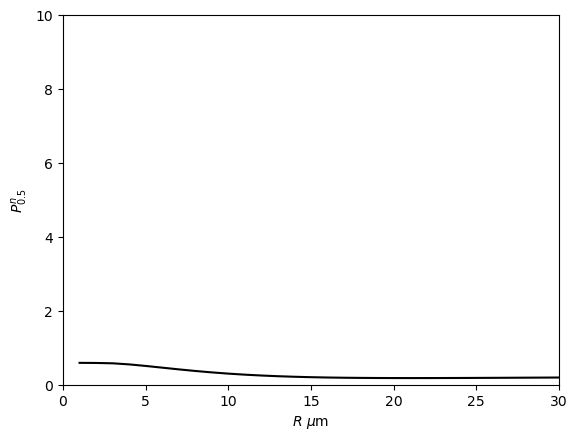

In [32]:
n = 3e10
Pn = pressure.P_n(n,-P_het,sigma(R,a_sigma,b_sigma,c_sigma))
print('Pression de ', round(Pn[0]*1e-6,1),' MPa, pour un rayon de ', R[0]*1e6, ' micromètre')
print('Pression de ', round(Pn[4]*1e-6,1),' MPa, pour un rayon de ', R[4]*1e6, ' micromètre')
plt.plot(R*1e6,Pn*1e-6,'k')
plt.xlabel('$R$ $\mu$m')
plt.ylabel('$P^{n}_{0.5}$')
plt.xlim(0,30)
plt.ylim(0,10)

et la courbe de probabilité donne

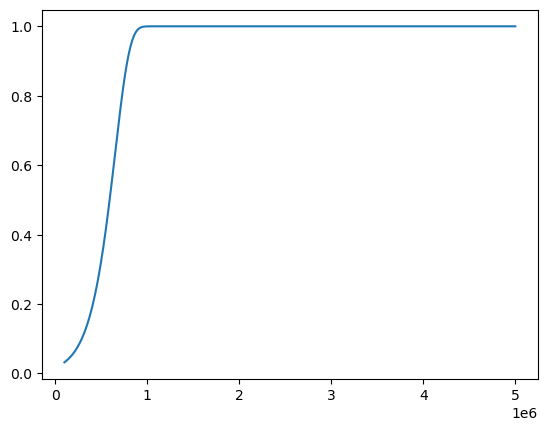

In [33]:
P = np.arange(0.1,5.01,0.01)*1e6
plt.plot(P, pressure.p_n(n,P,-P_het[0],sigma(R[0],a_sigma,b_sigma,c_sigma)))